This flocking example is based on the following colab notebook:  
https://github.com/google/jax-md/blob/main/notebooks/flocking.ipynb

In [8]:
import jax
from jax import numpy as jnp
from IPython.display import Image as DisplayImage

import evojax
from evojax import Trainer
from evojax.policy import MLPPolicy
from evojax.algo import PGPE
from evojax.task.flocking import FlockingTask
from evojax.util import create_logger

In [2]:
# Let's create a directory to save logs and models.
log_dir = './log'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('Welcome to the tutorial on Task creation!')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

EvoJAX: 2022-03-27 07:21:16,366 [INFO] Welcome to the tutorial on Task creation!
absl: 2022-03-27 07:21:16,373 [INFO] Starting the local TPU driver.
absl: 2022-03-27 07:21:16,375 [INFO] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
absl: 2022-03-27 07:21:16,549 [INFO] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
EvoJAX: 2022-03-27 07:21:16,550 [INFO] Jax backend: [GpuDevice(id=0, process_index=0)]


NVIDIA A100-SXM4-40GB


## Compare Reward Functions
In flocking.py, the reward function can be selected at init.  

- When reward_type = 0  
Normal reward function.

- When reward_type = 1  
The reward is made to be larger in the future.

Let's look at the difference between two reward functions.

### Normal reward function

In [3]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, reward_type=0)
test_task = FlockingTask(150, reward_type=0)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 07:21:19,624 [INFO] MLPPolicy.num_params = 2321
EvoJAX: 2022-03-27 07:21:19,725 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 07:21:23,715 [INFO] Iter=10, size=64, max=-127.7900, avg=-146.4117, min=-165.4250, std=8.0690
EvoJAX: 2022-03-27 07:21:24,203 [INFO] Iter=20, size=64, max=-128.7990, avg=-149.7366, min=-214.1909, std=16.6223
EvoJAX: 2022-03-27 07:21:24,675 [INFO] Iter=30, size=64, max=-124.8118, avg=-133.1313, min=-161.8011, std=6.3649
EvoJAX: 2022-03-27 07:21:26,703 [INFO] [TEST] Iter=30, #tests=10, max=-111.1290 avg=-126.1089, min=-147.3589, std=10.3716
EvoJAX: 2022-03-27 07:21:27,293 [INFO] Iter=40, size=64, max=-123.5997, avg=-136.2783, min=-154.6479, std=5.8608
EvoJAX: 2022-03-27 07:21:27,757 [INFO] Iter=50, size=64, max=-127.3910, avg=-140.4068, min=-161.9044, std=7.4548
EvoJAX: 2022-03-27 07:21:28,220 [INFO] Iter=60, size=64, max=-121.8569, avg=-130.2604, min=-150.1369, std=5.0782
EvoJAX: 2022-03-27 07:21:28,263 [INFO] [TEST] Iter=60, #te

reward=[-116.31797]


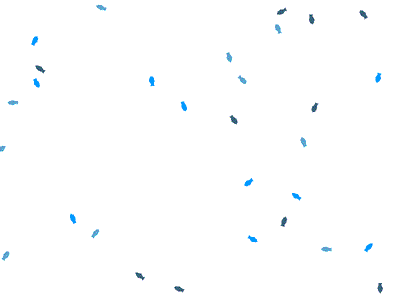

In [4]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list1 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### larger future rewards

In [5]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 07:24:29,659 [INFO] MLPPolicy.num_params = 2321
EvoJAX: 2022-03-27 07:24:29,745 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 07:24:31,477 [INFO] Iter=10, size=64, max=-34.6810, avg=-48.0137, min=-59.7731, std=4.9891
EvoJAX: 2022-03-27 07:24:31,951 [INFO] Iter=20, size=64, max=-38.3265, avg=-46.2025, min=-73.0190, std=6.2058
EvoJAX: 2022-03-27 07:24:32,412 [INFO] Iter=30, size=64, max=-36.7396, avg=-40.9785, min=-52.4116, std=3.2609
EvoJAX: 2022-03-27 07:24:33,470 [INFO] [TEST] Iter=30, #tests=10, max=-32.7647 avg=-36.6112, min=-43.2537, std=3.2469
EvoJAX: 2022-03-27 07:24:33,963 [INFO] Iter=40, size=64, max=-36.0466, avg=-41.5579, min=-50.8511, std=3.4881
EvoJAX: 2022-03-27 07:24:34,425 [INFO] Iter=50, size=64, max=-36.0223, avg=-42.3165, min=-55.9317, std=4.7263
EvoJAX: 2022-03-27 07:24:34,893 [INFO] Iter=60, size=64, max=-34.5746, avg=-39.0043, min=-51.8323, std=4.1976
EvoJAX: 2022-03-27 07:24:34,939 [INFO] [TEST] Iter=60, #tests=10, max=-31.9202 av

reward=[-30.070675]


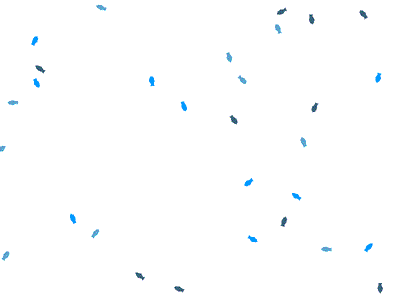

In [6]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list2 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking2.gif')
DisplayImage('flocking2.gif', format='png')

It can be seen the larger the future reward, eventually the more equally aligned the fishes become.  

We don't know if changing the reward function caused more collisions or slow alignment.  
So, let's output the angle transitions to a graph.  

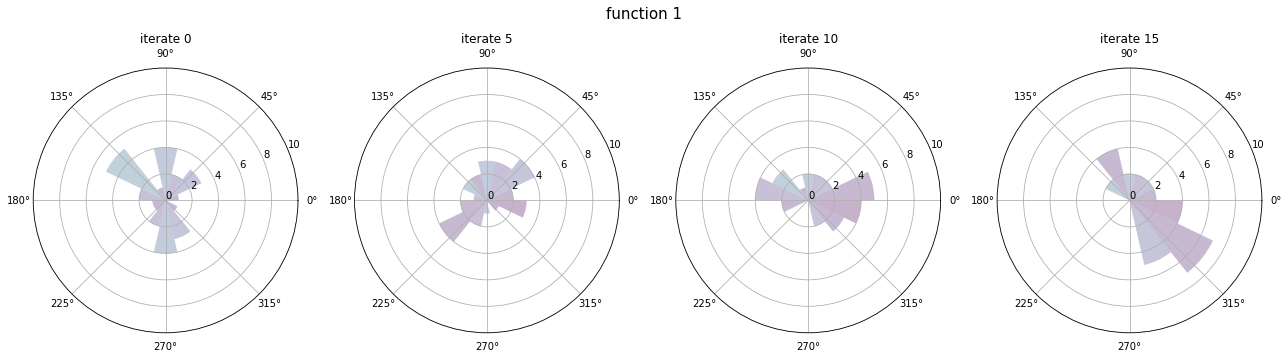

In [14]:
import numpy as np
import matplotlib.pyplot as plt

theta_list1 = []

for i in range(0, 4):
    theta_list1.append(np.mod(state_list1[i*5][:, 2], np.pi*2))

divi_num = 15
x = np.linspace(0, 2 * np.pi, divi_num)
width = x[1]

count1 = np.zeros(shape=(4, divi_num))

for i in range(0, 4):
    for j in range(0, divi_num-1):
        count1[i][j] = np.sum(np.where((theta_list1[i]>x[j]) & (theta_list1[i]<x[j+1]), 1, 0))

fig = plt.figure(figsize=(18, 5), tight_layout=True)

x = np.linspace(0, 2 * np.pi, divi_num)
colors = plt.cm.viridis(count1[0] / divi_num)

for i in range(0, 4):
    ax = plt.subplot(1, 4, i+1, projection="polar")
    ax.bar(x, count1[i], width=width, bottom=0.0, color=colors, alpha=0.3, align='edge')
    ax.set_yticks(np.arange(0, 11, 2))
    ax.set_title('iterate ' + str(5*i))

fig.suptitle('function 1', fontsize=15)
plt.savefig('circle_plot1.png')
plt.show()


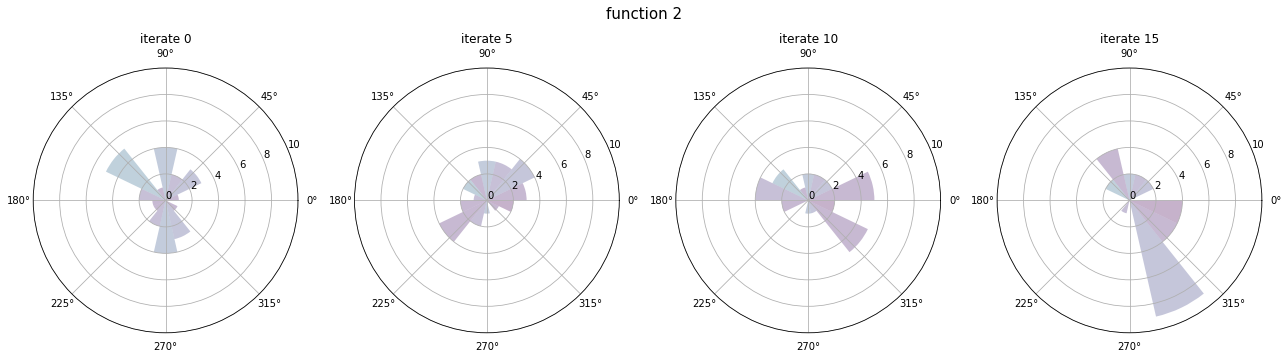

In [15]:
theta_list2 = []

for i in range(0, 4):
    theta_list2.append(np.mod(state_list2[i*5][:, 2], np.pi*2))

count2 = np.zeros(shape=(4, divi_num))

for i in range(0, 4):
    for j in range(0, divi_num-1):
        count2[i][j] = np.sum(np.where((theta_list2[i]>x[j]) & (theta_list2[i]<x[j+1]), 1, 0))

fig = plt.figure(figsize=(18, 5), tight_layout=True)

for i in range(0, 4):
    ax = plt.subplot(1, 4, i+1, projection="polar")
    ax.bar(x, count2[i], width=width, bottom=0.0, color=colors, alpha=0.3, align='edge')
    ax.set_yticks(np.arange(0, 11, 2))
    ax.set_title('iterate ' + str(5*i))

fig.suptitle('function 2', fontsize=15)
plt.savefig('circle_plot2.png')
plt.show()


No significant change in Alignment performance was seeb.  
This is probably why there are more initial collisions.

# Change Parameters
Flocking task has many parameters. Let's change some of them.

## Observation
In this task, the fishes observe the states of the nearest 5 fishes in default.  
If they are changed to other values, let's see what happens.

### M = 2

In [16]:
seed = 42
neighbor_num = 2
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 07:51:02,285 [INFO] MLPPolicy.num_params = 1961
EvoJAX: 2022-03-27 07:51:02,389 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 07:51:04,703 [INFO] Iter=10, size=64, max=-31.5658, avg=-37.1188, min=-54.0823, std=4.6585
EvoJAX: 2022-03-27 07:51:05,186 [INFO] Iter=20, size=64, max=-31.2997, avg=-34.2821, min=-39.2858, std=1.9319
EvoJAX: 2022-03-27 07:51:05,640 [INFO] Iter=30, size=64, max=-31.9429, avg=-36.5603, min=-53.6031, std=3.8797
EvoJAX: 2022-03-27 07:51:06,905 [INFO] [TEST] Iter=30, #tests=10, max=-29.1179 avg=-32.6947, min=-39.1656, std=2.7756
EvoJAX: 2022-03-27 07:51:07,369 [INFO] Iter=40, size=64, max=-30.0018, avg=-32.7416, min=-36.5203, std=1.4170
EvoJAX: 2022-03-27 07:51:07,820 [INFO] Iter=50, size=64, max=-31.6398, avg=-33.7375, min=-39.1246, std=1.2524
EvoJAX: 2022-03-27 07:51:08,286 [INFO] Iter=60, size=64, max=-30.8599, avg=-32.4508, min=-34.0823, std=0.8067
EvoJAX: 2022-03-27 07:51:08,330 [INFO] [TEST] Iter=60, #tests=10, max=-29.1462 av

reward=[-30.035395]


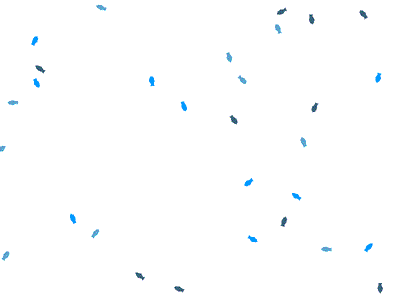

In [17]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        if step % 10 == 0:
            state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list1 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M = 3

In [18]:
seed = 42
neighbor_num = 3
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 07:54:09,665 [INFO] MLPPolicy.num_params = 2081
EvoJAX: 2022-03-27 07:54:09,768 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 07:54:12,072 [INFO] Iter=10, size=64, max=-34.5466, avg=-45.8520, min=-72.4757, std=8.4337
EvoJAX: 2022-03-27 07:54:12,561 [INFO] Iter=20, size=64, max=-34.5002, avg=-37.6745, min=-42.6221, std=1.9477
EvoJAX: 2022-03-27 07:54:13,020 [INFO] Iter=30, size=64, max=-32.6757, avg=-35.0699, min=-42.3416, std=1.7584
EvoJAX: 2022-03-27 07:54:14,172 [INFO] [TEST] Iter=30, #tests=10, max=-28.4822 avg=-31.5661, min=-41.2948, std=3.8536
EvoJAX: 2022-03-27 07:54:14,645 [INFO] Iter=40, size=64, max=-31.4904, avg=-33.9769, min=-38.5435, std=1.6301
EvoJAX: 2022-03-27 07:54:15,102 [INFO] Iter=50, size=64, max=-31.9728, avg=-34.2881, min=-39.4741, std=1.4072
EvoJAX: 2022-03-27 07:54:15,575 [INFO] Iter=60, size=64, max=-31.1566, avg=-32.9461, min=-36.9829, std=1.0488
EvoJAX: 2022-03-27 07:54:15,621 [INFO] [TEST] Iter=60, #tests=10, max=-28.7233 av

reward=[-29.227312]


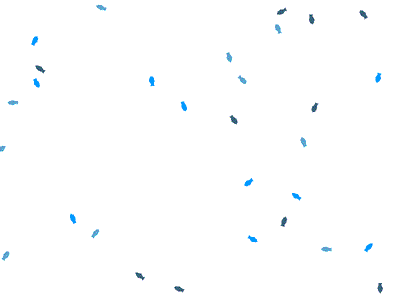

In [19]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M=7

In [20]:
seed = 42
neighbor_num = 7
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 07:57:14,894 [INFO] MLPPolicy.num_params = 2561
EvoJAX: 2022-03-27 07:57:15,006 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 07:57:17,522 [INFO] Iter=10, size=64, max=-38.0263, avg=-44.3599, min=-52.5114, std=3.3828
EvoJAX: 2022-03-27 07:57:17,993 [INFO] Iter=20, size=64, max=-37.9464, avg=-43.4288, min=-49.8061, std=2.9594
EvoJAX: 2022-03-27 07:57:18,462 [INFO] Iter=30, size=64, max=-36.4179, avg=-41.3283, min=-49.1213, std=2.2481
EvoJAX: 2022-03-27 07:57:19,654 [INFO] [TEST] Iter=30, #tests=10, max=-35.5354 avg=-39.9702, min=-47.7387, std=3.2152
EvoJAX: 2022-03-27 07:57:20,159 [INFO] Iter=40, size=64, max=-36.6607, avg=-40.6081, min=-47.5247, std=2.2370
EvoJAX: 2022-03-27 07:57:20,627 [INFO] Iter=50, size=64, max=-36.4391, avg=-41.0231, min=-48.4399, std=2.1985
EvoJAX: 2022-03-27 07:57:21,114 [INFO] Iter=60, size=64, max=-36.3616, avg=-39.7288, min=-46.6843, std=1.6152
EvoJAX: 2022-03-27 07:57:21,159 [INFO] [TEST] Iter=60, #tests=10, max=-34.5097 av

reward=[-43.715675]


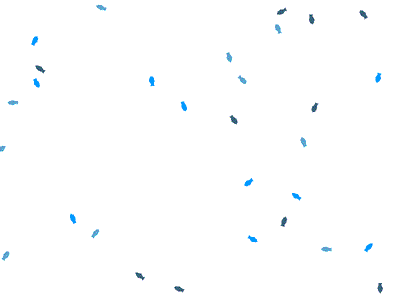

In [21]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M = 9

In [22]:
seed = 42
neighbor_num = 9
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 08:00:20,832 [INFO] MLPPolicy.num_params = 2801
EvoJAX: 2022-03-27 08:00:20,936 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 08:00:23,350 [INFO] Iter=10, size=64, max=-40.1510, avg=-46.4492, min=-52.8467, std=3.0338
EvoJAX: 2022-03-27 08:00:23,826 [INFO] Iter=20, size=64, max=-38.9034, avg=-44.8300, min=-53.7918, std=2.8942
EvoJAX: 2022-03-27 08:00:24,310 [INFO] Iter=30, size=64, max=-36.8804, avg=-43.5749, min=-49.0877, std=2.9294
EvoJAX: 2022-03-27 08:00:25,489 [INFO] [TEST] Iter=30, #tests=10, max=-33.3312 avg=-42.2650, min=-53.3492, std=5.0290
EvoJAX: 2022-03-27 08:00:25,972 [INFO] Iter=40, size=64, max=-39.1224, avg=-44.8099, min=-50.7646, std=2.8019
EvoJAX: 2022-03-27 08:00:26,466 [INFO] Iter=50, size=64, max=-39.6840, avg=-44.1770, min=-48.8659, std=2.0249
EvoJAX: 2022-03-27 08:00:26,942 [INFO] Iter=60, size=64, max=-39.0713, avg=-43.8319, min=-50.6449, std=2.5060
EvoJAX: 2022-03-27 08:00:26,986 [INFO] [TEST] Iter=60, #tests=10, max=-35.0148 av

reward=[-44.243248]


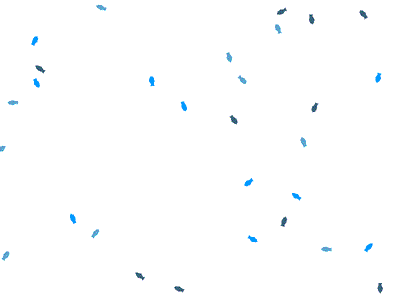

In [23]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M = 11

In [24]:
seed = 42
neighbor_num = 11
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 08:03:22,608 [INFO] MLPPolicy.num_params = 3041
EvoJAX: 2022-03-27 08:03:22,708 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 08:03:25,169 [INFO] Iter=10, size=64, max=-34.4437, avg=-40.6592, min=-49.2614, std=3.2035
EvoJAX: 2022-03-27 08:03:25,687 [INFO] Iter=20, size=64, max=-35.9301, avg=-38.8945, min=-49.5575, std=2.1753
EvoJAX: 2022-03-27 08:03:26,175 [INFO] Iter=30, size=64, max=-34.7116, avg=-37.5491, min=-45.2136, std=1.5796
EvoJAX: 2022-03-27 08:03:27,619 [INFO] [TEST] Iter=30, #tests=10, max=-32.7755 avg=-36.4195, min=-46.4112, std=3.9580
EvoJAX: 2022-03-27 08:03:28,111 [INFO] Iter=40, size=64, max=-35.7868, avg=-38.8447, min=-44.0920, std=1.6652
EvoJAX: 2022-03-27 08:03:28,607 [INFO] Iter=50, size=64, max=-36.1793, avg=-38.9095, min=-41.5711, std=1.2330
EvoJAX: 2022-03-27 08:03:29,095 [INFO] Iter=60, size=64, max=-35.2319, avg=-37.8992, min=-42.5144, std=1.4610
EvoJAX: 2022-03-27 08:03:29,140 [INFO] [TEST] Iter=60, #tests=10, max=-31.5300 av

reward=[-36.088028]


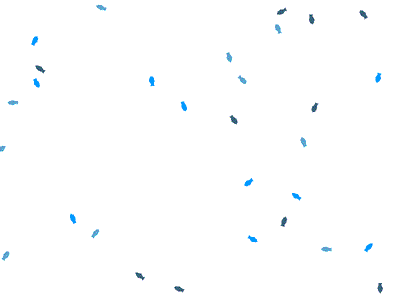

In [25]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

If we set M too large, the learning process will not proceed well.  
It turns out that they behave completely differently depending on the NEIGHBOR_NUM.

## Allowable angle of rotation
If the allowable angle of rotation were increased, collisions might be easier to avoid.
Let's try it.

In [37]:
seed = 42
neighbor_num = 5
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num
evojax.task.flocking.SPEED = 0.025
evojax.task.flocking.DT = 0.6

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 08:28:42,638 [INFO] MLPPolicy.num_params = 2321
EvoJAX: 2022-03-27 08:28:42,705 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 08:28:44,464 [INFO] Iter=10, size=64, max=-40.2273, avg=-55.9631, min=-139.0797, std=16.0353
EvoJAX: 2022-03-27 08:28:44,949 [INFO] Iter=20, size=64, max=-45.6727, avg=-57.2404, min=-79.4085, std=6.5589
EvoJAX: 2022-03-27 08:28:45,411 [INFO] Iter=30, size=64, max=-41.0941, avg=-46.5215, min=-81.2813, std=5.8590
EvoJAX: 2022-03-27 08:28:46,507 [INFO] [TEST] Iter=30, #tests=10, max=-37.8014 avg=-45.0531, min=-48.6468, std=3.2096
EvoJAX: 2022-03-27 08:28:46,987 [INFO] Iter=40, size=64, max=-39.9814, avg=-46.8460, min=-76.4881, std=6.9163
EvoJAX: 2022-03-27 08:28:47,463 [INFO] Iter=50, size=64, max=-41.7705, avg=-47.5499, min=-72.5385, std=4.6918
EvoJAX: 2022-03-27 08:28:47,926 [INFO] Iter=60, size=64, max=-47.1713, avg=-52.6043, min=-61.0615, std=3.2920
EvoJAX: 2022-03-27 08:28:47,984 [INFO] [TEST] Iter=60, #tests=10, max=-37.2471 

reward=[-41.569878]


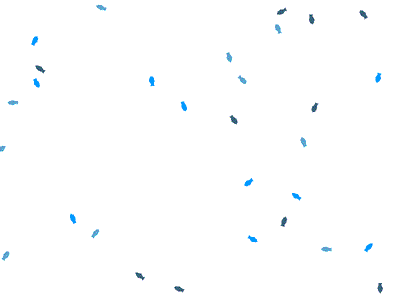

In [38]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

Unintentionally, they have learned to rotate on the spot.  
It is true that rotating in place like other fish satisfies Alignment and Avoidance....

In [30]:
seed = 42
neighbor_num = 5

evojax.task.flocking.NEIGHBOR_NUM = neighbor_num
evojax.task.flocking.SPEED = 0.12
evojax.task.flocking.DT = 0.2

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1, 1)
test_task = FlockingTask(150, 1, 1)

policy = MLPPolicy(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[40, 40],
    output_dim=train_task.act_shape[0],
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-27 08:16:27,994 [INFO] MLPPolicy.num_params = 2362
EvoJAX: 2022-03-27 08:16:28,068 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-27 08:16:29,762 [INFO] Iter=10, size=64, max=-37.2692, avg=-43.4441, min=-53.6798, std=3.3131
EvoJAX: 2022-03-27 08:16:30,268 [INFO] Iter=20, size=64, max=-33.2977, avg=-41.5715, min=-50.9964, std=4.0649
EvoJAX: 2022-03-27 08:16:30,787 [INFO] Iter=30, size=64, max=-31.5969, avg=-35.7203, min=-42.6225, std=2.1773
EvoJAX: 2022-03-27 08:16:31,838 [INFO] [TEST] Iter=30, #tests=10, max=-31.3423 avg=-33.0192, min=-37.4813, std=1.7627
EvoJAX: 2022-03-27 08:16:32,379 [INFO] Iter=40, size=64, max=-28.5281, avg=-31.6291, min=-35.4481, std=1.5904
EvoJAX: 2022-03-27 08:16:32,899 [INFO] Iter=50, size=64, max=-27.7900, avg=-29.9976, min=-36.5329, std=1.8514
EvoJAX: 2022-03-27 08:16:33,403 [INFO] Iter=60, size=64, max=-27.1294, avg=-29.5485, min=-39.1416, std=2.3828
EvoJAX: 2022-03-27 08:16:33,451 [INFO] [TEST] Iter=60, #tests=10, max=-26.4851 av

## Learning Speed
In task/flocking, not only angles but also speed can be learned.  
Learning speed may help to avoid collisions and to align more neatly. Let's give it a try.

reward=[-25.980398]


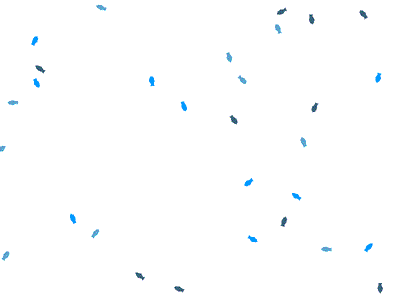

In [31]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

We saw a cleaner alignment than in the first example.  
By changing the parameters, we may be able to see more interesting behaviors.